In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm

In [2]:
from google.colab import files
uploaded = files.upload()

Saving user-wallet-transactions.json to user-wallet-transactions (1).json


In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

In [5]:
json_filename = "user-wallet-transactions.json"
with open(json_filename, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# Extract the 'amount' from the 'actionData' dictionary and convert to float
df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)) if isinstance(x, dict) and x.get('amount') else 0)

In [7]:
def engineer_features(df):
    actions = ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']
    features = df.groupby('userWallet').agg(
        total_txn=('action', 'count'),
        total_volume=('amount', 'sum'),
        active_days=('timestamp', lambda x: x.dt.date.nunique()),
        avg_amount=('amount', 'mean')
    ).reset_index()

    for action in actions:
        action_df = df[df['action'] == action].groupby('userWallet').agg({ 'amount': ['sum', 'count'] })
        action_df.columns = [f'{action}_amount', f'{action}_count']
        action_df = action_df.reset_index()
        features = features.merge(action_df, on='userWallet', how='left')

    features.fillna(0, inplace=True)
    return features

features = engineer_features(df)

In [8]:
def create_heuristic_score(df):
    score = (
        df['deposit_amount'] * 0.2 +
        df['repay_amount'] * 0.2 -
        df['borrow_amount'] * 0.3 -
        df['liquidationcall_count'] * 50 +
        df['active_days'] * 2
    )
    scaled = MinMaxScaler((0, 1000)).fit_transform(score.values.reshape(-1, 1)).flatten()
    return scaled

features['score'] = create_heuristic_score(features)

In [10]:
X = features.drop(columns=['userWallet', 'score'])
y = features['score']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [11]:
pred_scores = model.predict(X)
pred_scores = MinMaxScaler((0, 1000)).fit_transform(pred_scores.reshape(-1, 1)).flatten()
features['score'] = pred_scores

In [13]:
features[['userWallet', 'score']].to_csv('wallet_scores.csv', index=False)
print("✅ Wallet scores saved to wallet_scores.csv")

✅ Wallet scores saved to wallet_scores.csv


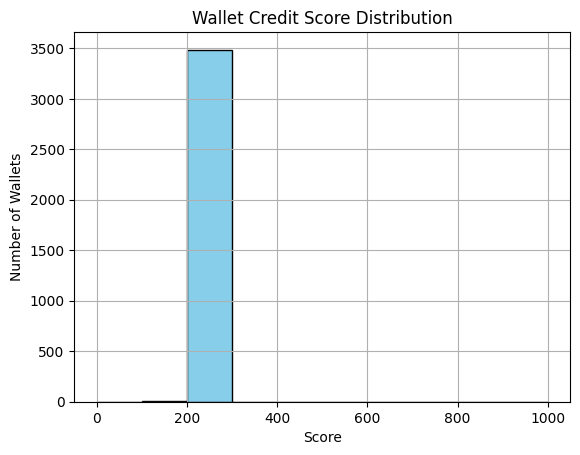

In [14]:
plt.hist(features['score'], bins=10, color='skyblue', edgecolor='black')
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()